# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 186
The number of columns: 494


In [3]:
# Bekijk de eerste rijen
print(data.head())

# Bekijk de kolomnamen en datatypes
print(data.dtypes)

# Samenvatting van de statistieken
print(data.describe())




                 label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                 
Liver-001_0     benign                                  0.878471   
Liver-002_0     benign                                  0.878945   
Liver-003_0     benign                                  0.766162   
Liver-004_0  malignant                                  0.825737   
Liver-005_0  malignant                                  0.828831   

             PREDICT_original_sf_compactness_std_2.5D  \
ID                                                      
Liver-001_0                                  0.023468   
Liver-002_0                                  0.039922   
Liver-003_0                                  0.064140   
Liver-004_0                                  0.062047   
Liver-005_0                                  0.062635   

             PREDICT_original_sf_rad_dist_avg_2.5D  \
ID                                                   
Liver-001_0    

<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
C:\Users\jelle\AppData\Local\Temp\ipykernel_28372\2669204061.py:14: SyntaxWarning: invalid escape sequence '\T'
  data = pd.read_excel("..\TrainData.xlsx")


Vorm van de data: (139, 494)
Kolommen: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origin

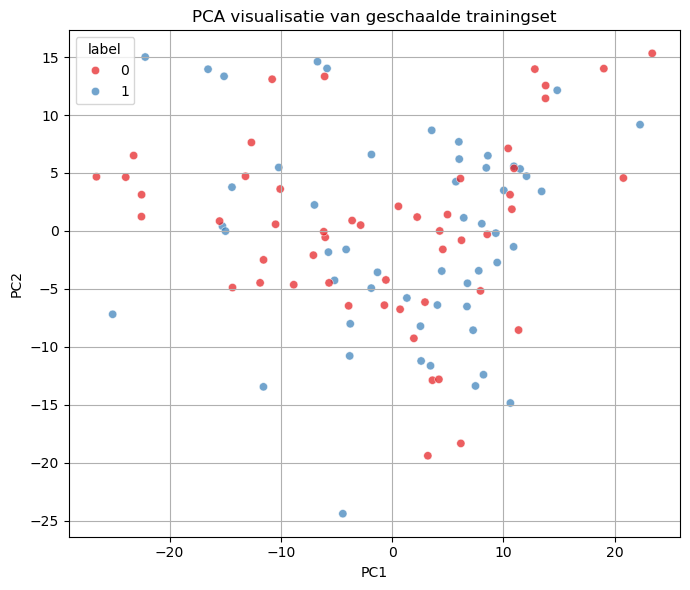

c:\Users\jelle\OneDrive - Delft University of Technology\10007 Machine learning\.conda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 76  77  83  84  85  90  96  97 103 109 110 467 474 475 480 487 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\jelle\OneDrive - Delft University of Technology\10007 Machine learning\.conda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Top 10 features volgens SelectKBest: ['PREDICT_original_hf_std', 'PREDICT_original_hf_quartile_range', 'PREDICT_original_tf_LBP_median_R3_P12', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDICT_original_tf_LBP_skewness_R3_P12', 'PREDICT_original_tf_LBP_mean_R8_P24', 'PREDICT_original_tf_LBP_std_R8_P24', 'PREDICT_original_tf_LBP_skewness_R8_P24', 'PREDICT_original_tf_LBP_kurtosis_R8_P24', 'PREDICT_original_tf_LBP_quartile_range_R8_P24']
Top 10 belangrijke features volgens RF:
 PREDICT_original_vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0             0.015541
PREDICT_original_tf_LBP_skewness_R3_P12                               0.015344
PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0    0.014167
PREDICT_original_tf_LBP_std_R8_P24                                    0.012661
PREDICT_original_tf_LBP_std_R3_P12                                    0.012308
PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0    0.011533
PREDICT_original_tf_Gabor_median_F0.5_A0.0      

In [18]:
# 📦 Vereiste imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧾 Stap 1 – Laad de data
data = pd.read_excel("..\TrainData.xlsx")

# 🔍 Eerste inspectie
print("Vorm van de data:", data.shape)
print("Kolommen:", data.columns.tolist())
print("Aantal duplicaten:", data.duplicated().sum())
print("Missende waarden per kolom:")
print(data.isnull().sum())

# 🧼 Stap 2 – Dubbele rijen verwijderen
data = data.drop_duplicates()

# 🎯 Stap 3 – Split in features en labels
X = data.drop(columns="label")
y = data["label"]

# 🔁 Zet y om naar numeriek met behoud van pandas Series
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)

# ❓ Hoeveel missende waarden blijven over?
print("Totaal aantal missende waarden:", X.isnull().sum().sum())

# ⚠️ Stap 4 – NaNs imputer (mediaan)
X = X.fillna(X.median(numeric_only=True))

# 📏 Stap 5 – Train-test split (eerlijk en met stratificatie)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# 📊 Evaluatie via meerdere metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# 🔁 Vergelijking van scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, scaler in scalers.items():
    X_train_scaled_tmp = scaler.fit_transform(X_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_validate(model, X_train_scaled_tmp, y_train, cv=cv, scoring=scoring)

    results[name] = {
        'mean_accuracy': np.mean(scores['test_accuracy']),
        'mean_f1': np.mean(scores['test_f1']),
        'mean_auc': np.mean(scores['test_roc_auc'])
    }

# 📋 Print overzicht
print("\n🔍 Vergelijking van scalers op basis van Accuracy, F1 en ROC AUC:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['mean_accuracy']:.3f}, "
          f"F1 = {res['mean_f1']:.3f}, "
          f"AUC = {res['mean_auc']:.3f}")

# ✅ Beste scaler kiezen op basis van AUC (pas dit aan naar 'mean_f1' of 'mean_accuracy' indien gewenst)
best_scaler_name = max(results.items(), key=lambda x: x[1]['mean_auc'])[0]
print(f"\n✅ Beste scaler op basis van AUC: {best_scaler_name}")

# 🔁 Gebruik de beste scaler voor de rest van de pipeline
scaler = scalers[best_scaler_name]
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


## tot hier pre-processing

## vanaf hier feature slection

# ⚖️ Stap 6 – Balans controleren
print("\nLabelverdeling in training set:\n", y_train.value_counts(normalize=True))
print("Labelverdeling in test set:\n", y_valid.value_counts(normalize=True))

# 📉 Stap 7 – PCA visualisatie (alleen op trainingset)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y_train.values  # y_train is een Series, dus .values werkt nu

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie van geschaalde trainingset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Stap 8 – Univariate feature selectie
selector = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector.fit_transform(X_train_scaled, y_train)
selected_kbest = X_train.columns[selector.get_support()]
print("Top 10 features volgens SelectKBest:", selected_kbest.tolist())

# 🌳 Stap 9 – Random Forest Feature Importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)
print("Top 10 belangrijke features volgens RF:\n", top_features)

# 🔁 Stap 10 – RFECV (wrapper methode)
#rfecv = RFECV(
#    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
#    step=1, cv=cv, scoring='accuracy', n_jobs=-1
#)
#rfecv.fit(X_train_scaled, y_train)
#selected_rfecv = X_train.columns[rfecv.support_]
#print(f"Aantal geselecteerde features via RFECV: {len(selected_rfecv)}")
#print("Features geselecteerd via RFECV:\n", selected_rfecv.tolist())


In [69]:
#nog een functie

def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

Misclassified: 23 / 35


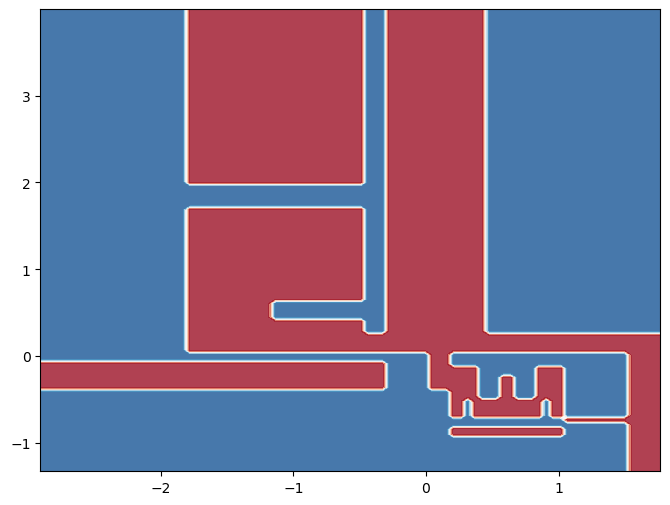

In [ ]:
#X_train_scaled, X_valid_scaled, y_train, y_valid

# start with decision tree classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

n_tree = 1
clf = DecisionTreeClassifier(random_state=3)
clf.fit(X_train_scaled[:,0:2], y_train)

y_pred = clf.predict(X_valid_scaled[:,0:2])
print("Misclassified: %d / %d" % ((y_valid != y_pred).sum(), X_valid_scaled.shape[0]))

fig, ax = plt.subplots(figsize=(8, 6))

#ax.scatter(X, X[:, 1], marker='o', c=Y, s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X_valid_scaled[:,0], X_valid_scaled[:,1])



#Random forest 

# 1. kijk naar ensambling (avaring or voting), 
# 2. Hyperparameters optimalizaleren. (Bijvoorbeeld grafiek maken waarmee de optimale hoeveelheid bomen kan worden bepaald.) 
    # Hiermee kan bijvoorbeeld GridSearchCV and RandomizedSearchCV 
    # Dus eerst bij alle parameters apart ondrzoeken om bij een range uit te komen.
    # Daarna met GridSearchCV de echte parameters kiezen
    # nTree, min_sample_split, max_depth, min_samples_leaf, splitting 'gini'.
# 3. Feature importance goed weergeven.  








In [29]:
X_valid_scaled.shape

(35, 493)

In [32]:
y_train.shape

(104,)